In [1]:
import pandas as pd

# Load the data
trades = pd.read_csv(r"C:\Users\naray\OneDrive\Desktop\bitcoin internship\historical_data.csv")
sentiment = pd.read_csv(r"C:\Users\naray\OneDrive\Desktop\bitcoin internship\fear_greed_index.csv")

# Check column names
print(trades.columns)
print(sentiment.columns)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [2]:
# Convert the 'date' column in sentiment
sentiment['date'] = pd.to_datetime(sentiment['date'], format='%d-%m-%Y').dt.date

# Parse 'Timestamp IST' with correct format
trades['time_ist'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')
trades['date'] = trades['time_ist'].dt.date

# Merge
merged_ist = trades.merge(sentiment[['date', 'classification']], on='date', how='left')
merged_ist.rename(columns={'classification': 'sentiment'}, inplace=True)

# Preview
merged_ist.head()



,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,time_ist,date,sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed


In [3]:
# Count missing sentiment values
missing_count = merged_ist['sentiment'].isna().sum()
total_rows = len(merged_ist)

print(f"Missing sentiment rows: {missing_count} out of {total_rows} total rows")
print(f"Percentage missing: {missing_count / total_rows * 100:.2f}%")


Missing sentiment rows: 6 out of 211224 total rows
Percentage missing: 0.00%


In [4]:
# Drop rows with missing sentiment
cleaned_df = merged_ist.dropna(subset=['sentiment'])



In [5]:

# Handle outliers in Start Position using IQR method
Q1 = cleaned_df['Start Position'].quantile(0.25)
Q3 = cleaned_df['Start Position'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds (using 3*IQR to be less aggressive)
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Filter outliers
cleaned_df = cleaned_df[(cleaned_df['Start Position'] >= lower_bound) & 
                       (cleaned_df['Start Position'] <= upper_bound)]
# ===== END OF NEW SECTION =====
# Group by sentiment using MEDIAN for Start Position
summary = cleaned_df.groupby('sentiment').agg({
    'Closed PnL': 'mean',
    'Start Position': 'median',  # CHANGED FROM mean TO median
    'Size USD': 'mean',
    'Account': 'count'
}).rename(columns={
    'Closed PnL': 'Avg Closed PnL',
    'Start Position': 'Median Start Position',  # Renamed to reflect median
    'Size USD': 'Avg Trade Volume (USD)',
    'Account': 'Trade Count'
}).sort_index()

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'sentiment': ['Extreme Fear', 'Extreme Greed', 'Fear', 'Greed', 'Neutral'],
    'Avg Closed PnL': [34.537862, 67.892861, 54.290400, 42.743559, 34.307718],
    'Avg Start Position': [-2322.304587, 19518.990812, 8709.824822, -151088.546635, 144.002263],
    'Avg Trade Volume (USD)': [5349.731843, 3112.251565, 7816.109931, 5736.884375, 4782.732661],
    'Trade Count': [21400, 39992, 61837, 50303, 37686]
}

df = pd.DataFrame(data)

order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

C:\Users\naray\AppData\Local\Temp\ipykernel_11104\28434370.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='Avg Closed PnL', data=df, order=order, palette="coolwarm")


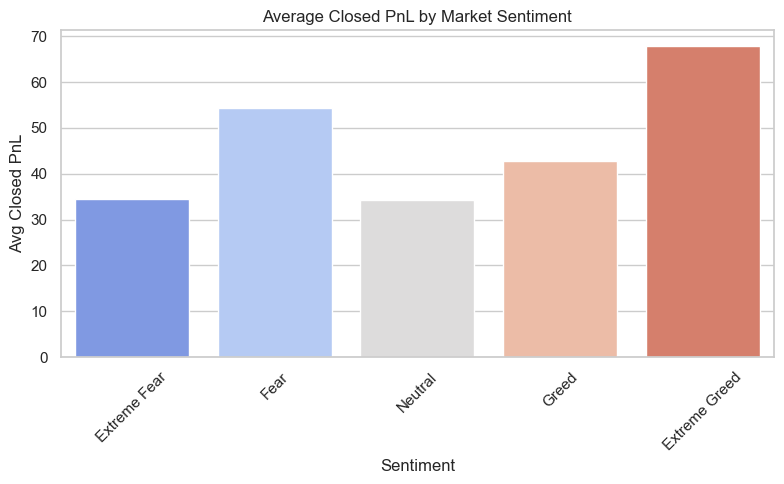

<Figure size 640x480 with 0 Axes>

In [47]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.barplot(x='sentiment', y='Avg Closed PnL', data=df, order=order, palette="coolwarm")
plt.title('Average Closed PnL by Market Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Avg Closed PnL')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()
plt.savefig('Average closed PnL by Market sentiment.png')  # saves to the current working directory by default


C:\Users\naray\AppData\Local\Temp\ipykernel_11104\1404005431.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary.index, y='Median Start Position', data=summary.reset_index(),


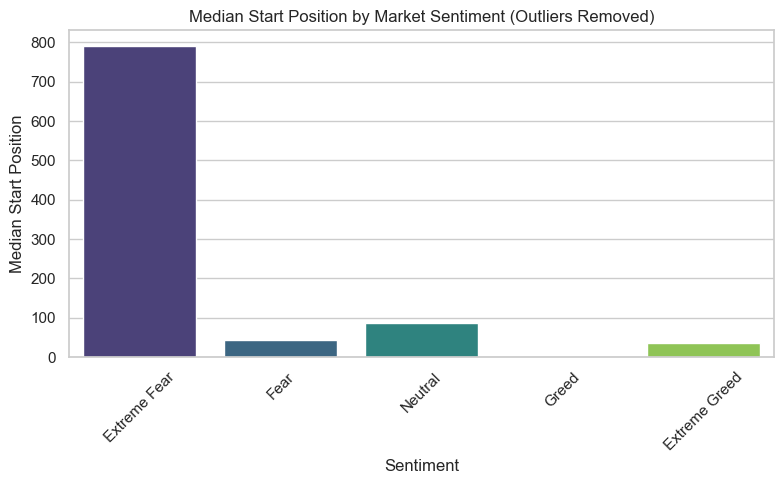

In [8]:
plt.figure(figsize=(8, 5))
sns.barplot(x=summary.index, y='Median Start Position', data=summary.reset_index(), 
            order=order, palette="viridis")
plt.title('Median Start Position by Market Sentiment (Outliers Removed)')
plt.xticks(rotation=45)
plt.ylabel('Median Start Position')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()

C:\Users\naray\AppData\Local\Temp\ipykernel_11104\1108928880.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='Avg Trade Volume (USD)', data=df, order=order, palette="magma")


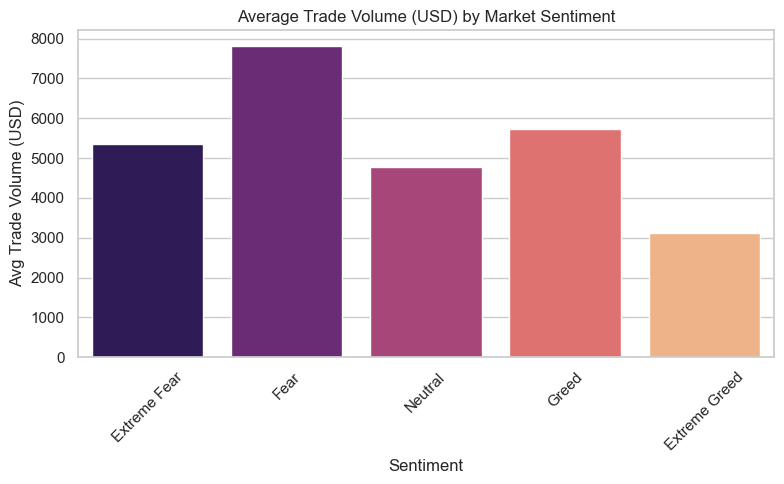

In [9]:

plt.figure(figsize=(8, 5))
sns.barplot(x='sentiment', y='Avg Trade Volume (USD)', data=df, order=order, palette="magma")
plt.title('Average Trade Volume (USD) by Market Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Avg Trade Volume (USD)')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()

C:\Users\naray\AppData\Local\Temp\ipykernel_11104\1416287416.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='Trade Count', data=df, order=order, palette="cubehelix")


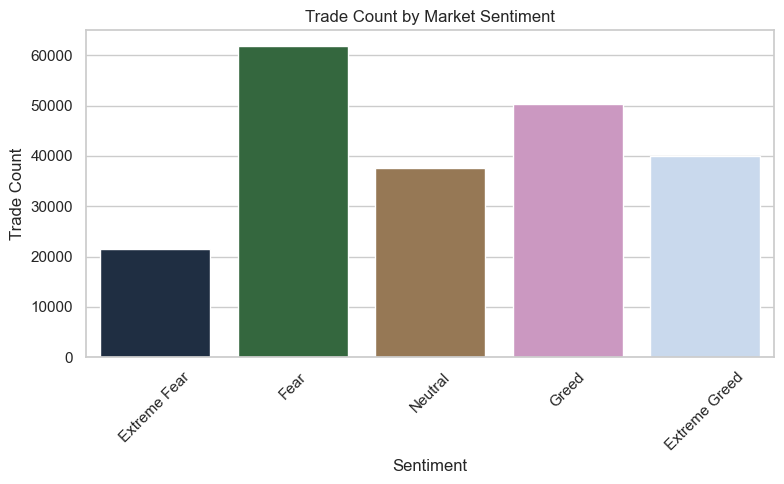

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(x='sentiment', y='Trade Count', data=df, order=order, palette="cubehelix")
plt.title('Trade Count by Market Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Trade Count')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()

C:\Users\naray\AppData\Local\Temp\ipykernel_11104\2748804211.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='Size USD', data=cleaned_df, order=order, palette="coolwarm")


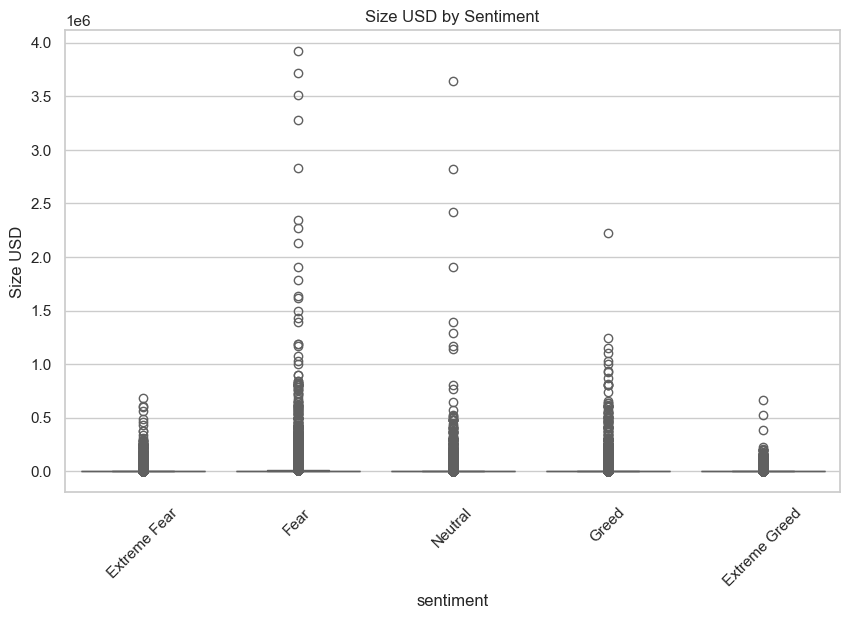

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='Size USD', data=cleaned_df, order=order, palette="coolwarm")
plt.title("Size USD by Sentiment")
plt.xticks(rotation=45)
plt.show()


C:\Users\naray\AppData\Local\Temp\ipykernel_11104\731959707.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='Start Position', data=cleaned_df, order=order, palette="coolwarm")


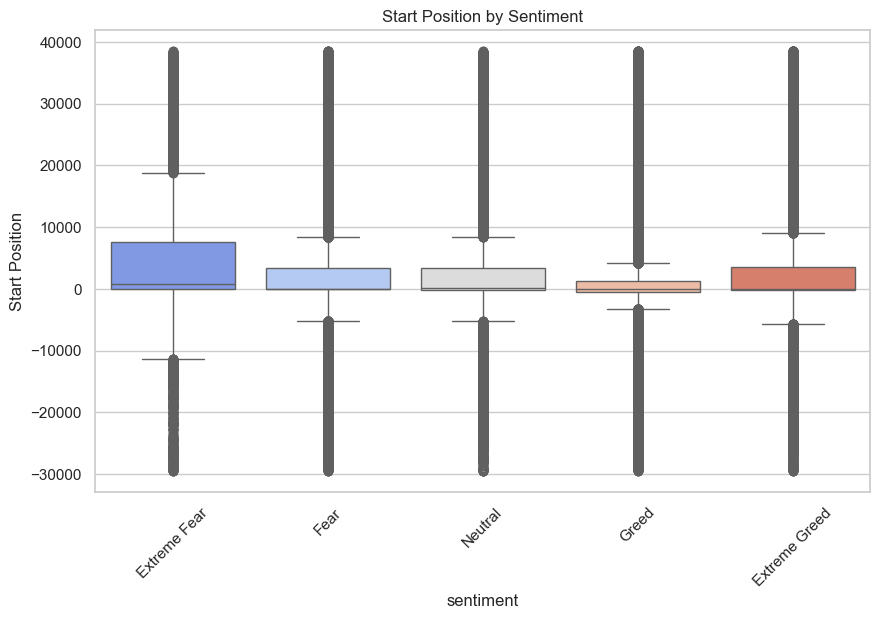

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='Start Position', data=cleaned_df, order=order, palette="coolwarm")
plt.title("Start Position by Sentiment")
plt.xticks(rotation=45)
plt.show()


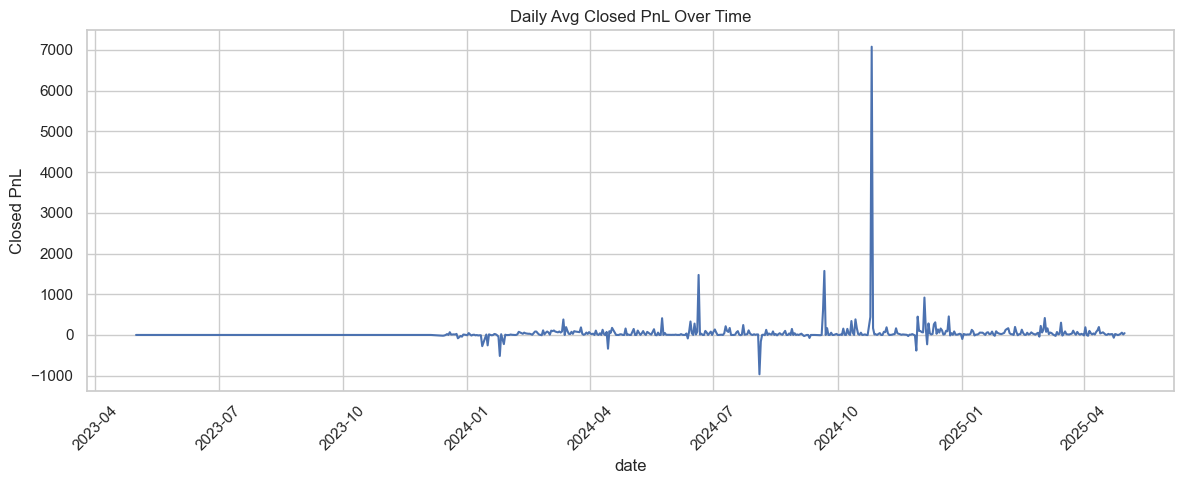

In [14]:
# Daily average PnL over time
daily_pnl = merged_ist.groupby('date')['Closed PnL'].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='Closed PnL', data=daily_pnl)
plt.title("Daily Avg Closed PnL Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


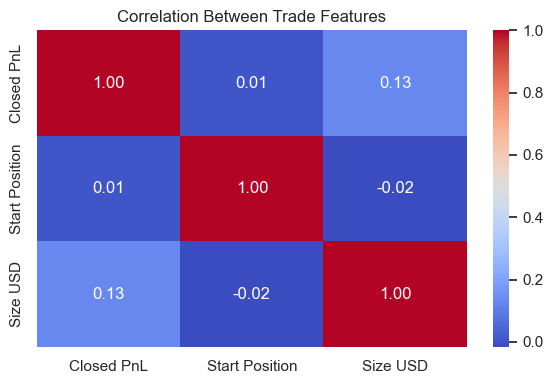

In [15]:
corr = cleaned_df[['Closed PnL', 'Start Position', 'Size USD']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Trade Features")
plt.tight_layout()
plt.show()


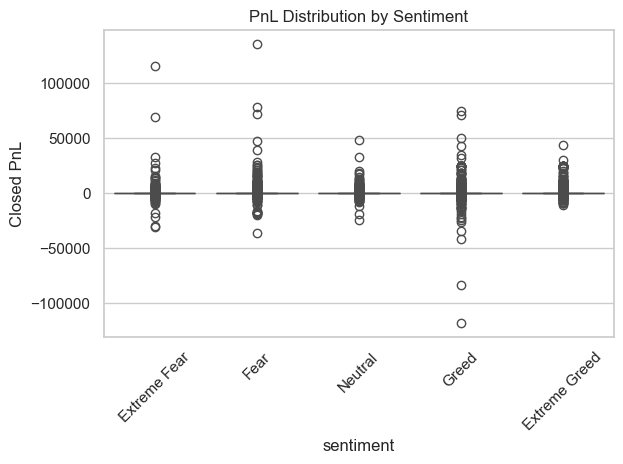

In [16]:
sns.boxplot(x='sentiment', y='Closed PnL', data=merged_ist, order=order)
plt.title('PnL Distribution by Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
from scipy.stats import shapiro

for sentiment, group in merged_ist.groupby("sentiment"):
    stat, p = shapiro(group['Closed PnL'])
    print(f"{sentiment}: p-value = {p:.4f}")


Extreme Fear: p-value = 0.0000
Extreme Greed: p-value = 0.0000
Fear: p-value = 0.0000
Greed: p-value = 0.0000
Neutral: p-value = 0.0000


C:\Users\naray\anaconda3\envs\trader_sentiment\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [18]:
from scipy.stats import kruskal

# Group Closed PnL by sentiment
groups = [group['Closed PnL'].values for _, group in merged_ist.groupby('sentiment')]

# Run Kruskal-Wallis test
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis test statistic = {stat:.4f}, p-value = {p:.4f}")


Kruskal-Wallis test statistic = 1226.9956, p-value = 0.0000


In [19]:
pip install scikit-posthocs


Note: you may need to restart the kernel to use updated packages.


In [20]:
import scikit_posthocs as sp
import pandas as pd

# Drop rows where sentiment or Closed PnL is NaN
clean_df = merged_ist.dropna(subset=['sentiment', 'Closed PnL'])

# Run Dunn's post-hoc test with Bonferroni correction
dunn_result = sp.posthoc_dunn(clean_df, val_col='Closed PnL', group_col='sentiment', p_adjust='bonferroni')

# Show result matrix
print(dunn_result)


                Extreme Fear  Extreme Greed          Fear          Greed  \
Extreme Fear    1.000000e+00  7.415834e-142  4.126575e-48   1.000000e+00   
Extreme Greed  7.415834e-142   1.000000e+00  2.134380e-52  9.099478e-200   
Fear            4.126575e-48   2.134380e-52  1.000000e+00   5.342048e-66   
Greed           1.000000e+00  9.099478e-200  5.342048e-66   1.000000e+00   
Neutral         6.298175e-06  3.796656e-127  7.282426e-29   1.351546e-04   

                     Neutral  
Extreme Fear    6.298175e-06  
Extreme Greed  3.796656e-127  
Fear            7.282426e-29  
Greed           1.351546e-04  
Neutral         1.000000e+00  


<Axes: xlabel='sentiment'>

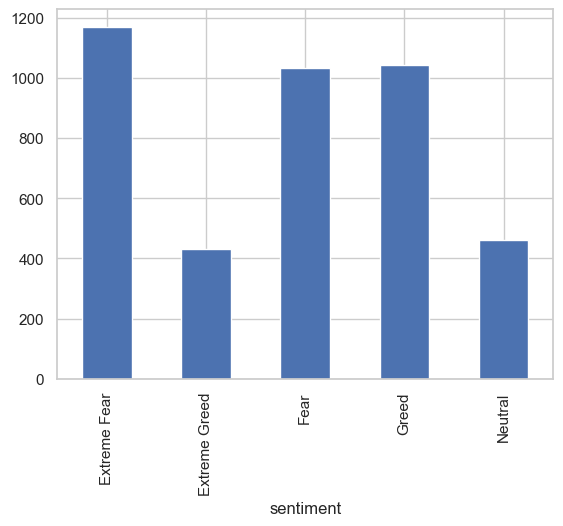

In [25]:
cleaned_df.groupby('sentiment')['Closed PnL'].std().plot(kind='bar')


In [28]:
# Calculate total trade volume (sum of Size USD) per sentiment and side
trade_volume = cleaned_df.groupby(['sentiment', 'Side'])['Size USD'].sum().unstack(fill_value=0)

# Calculate trade count (number of trades) per sentiment and side
trade_count = cleaned_df.groupby(['sentiment', 'Side']).size().unstack(fill_value=0)

# Average PnL per sentiment and side (you already have this)
avg_pnl = cleaned_df.groupby(['sentiment', 'Side'])['Closed PnL'].mean().unstack(fill_value=0)

# Combine all into one DataFrame
summary = pd.concat([
    trade_counts.add_prefix('Count_'),
    trade_pct.add_prefix('Pct_'),
    trade_count.add_prefix('TradeCount_'),
    trade_volume.add_prefix('TradeVolume_'),
    avg_pnl.add_prefix('AvgPnL_')
], axis=1)

# Round for readability
summary = summary.round(2)

print(summary)


Side           Count_BUY  Count_SELL  Pct_BUY  Pct_SELL  TradeCount_BUY  \
sentiment                                                                 
Extreme Fear        7780        8313    48.34     51.66            7780   
Extreme Greed      14793       17541    45.75     54.25           14793   
Fear               22992       23973    48.96     51.04           22992   
Greed              19698       20928    48.49     51.51           19698   
Neutral            16001       15312    51.10     48.90           16001   

Side           TradeCount_SELL  TradeVolume_BUY  TradeVolume_SELL  AvgPnL_BUY  \
sentiment                                                                       
Extreme Fear              8313     4.661335e+07      4.731065e+07       57.48   
Extreme Greed            17541     5.397563e+07      5.590594e+07        7.83   
Fear                     23973     2.265873e+08      2.141833e+08       63.02   
Greed                    20928     1.444770e+08      1.244472e+08    

In [35]:

# Desired sentiment order
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

# Reorder summary to match this order
ordered_summary = summary.loc[sentiment_order]

# Also reorder trade_pct
ordered_trade_pct = trade_pct.loc[sentiment_order]


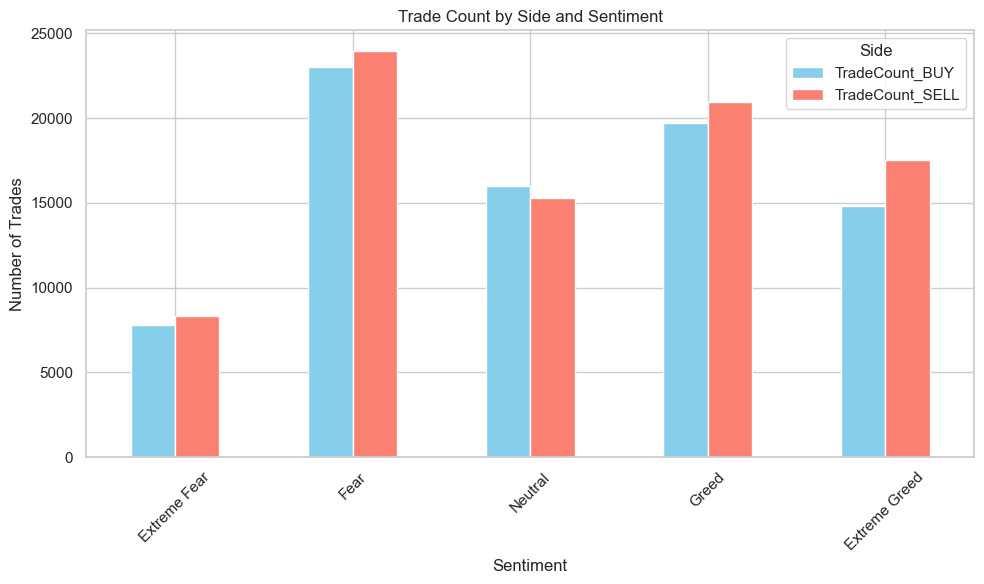

In [36]:
# Reorder the index of summary to match the desired sentiment order
ordered_summary = summary.loc[order]

# Plot trade counts by side
ordered_summary[['TradeCount_BUY', 'TradeCount_SELL']].plot(
    kind='bar',
    figsize=(10, 6),
    color=['skyblue', 'salmon']
)

plt.title('Trade Count by Side and Sentiment')
plt.ylabel('Number of Trades')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.legend(title='Side')
plt.tight_layout()
plt.show()



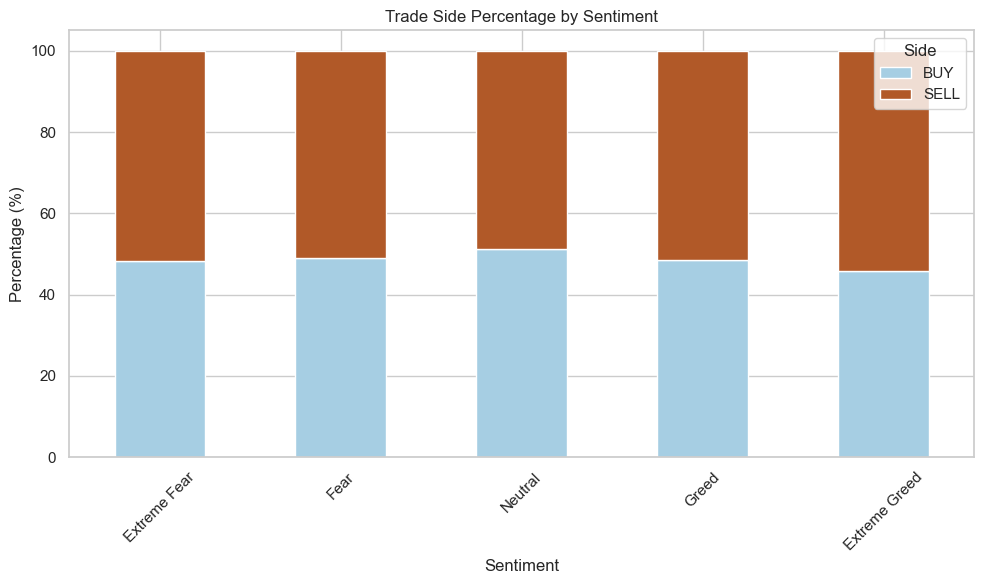

In [37]:
ordered_trade_pct.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6), 
    colormap='Paired'
)
plt.title("Trade Side Percentage by Sentiment")
plt.ylabel("Percentage (%)")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.legend(title='Side')
plt.tight_layout()
plt.show()




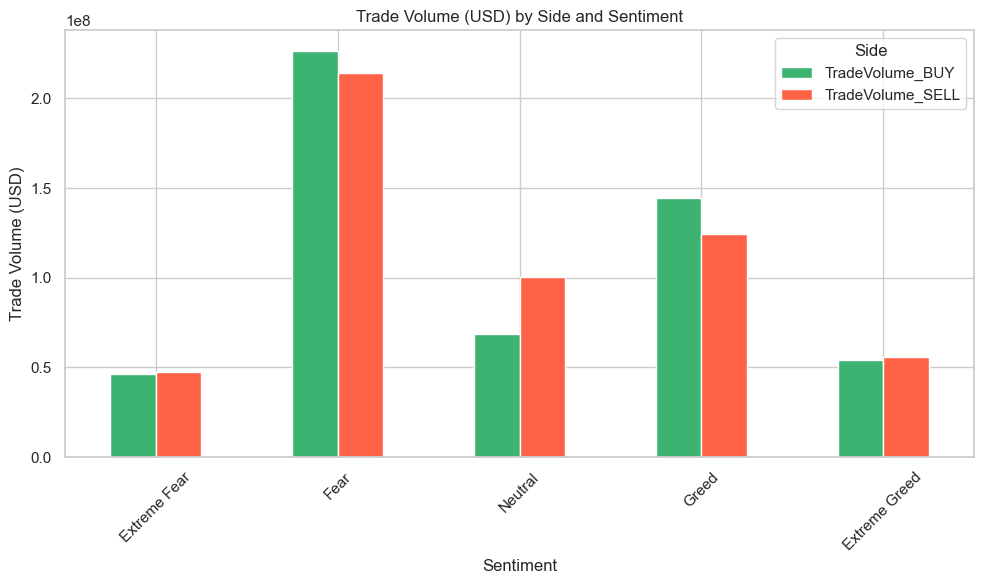

In [39]:
ordered_summary[['TradeVolume_BUY', 'TradeVolume_SELL']].plot(
    kind='bar', 
    figsize=(10, 6), 
    color=['mediumseagreen', 'tomato']
)
plt.title("Trade Volume (USD) by Side and Sentiment")
plt.ylabel("Trade Volume (USD)")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.legend(title='Side')
plt.tight_layout()
plt.show()


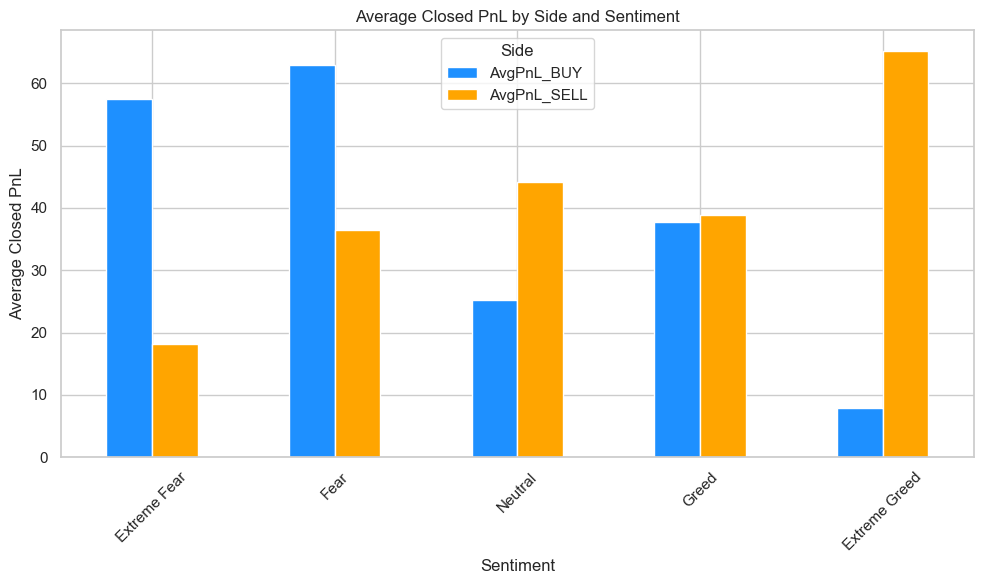

In [40]:
ordered_summary[['AvgPnL_BUY', 'AvgPnL_SELL']].plot(
    kind='bar', 
    figsize=(10, 6), 
    color=['dodgerblue', 'orange']
)
plt.title("Average Closed PnL by Side and Sentiment")
plt.ylabel("Average Closed PnL")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.legend(title='Side')
plt.tight_layout()
plt.show()


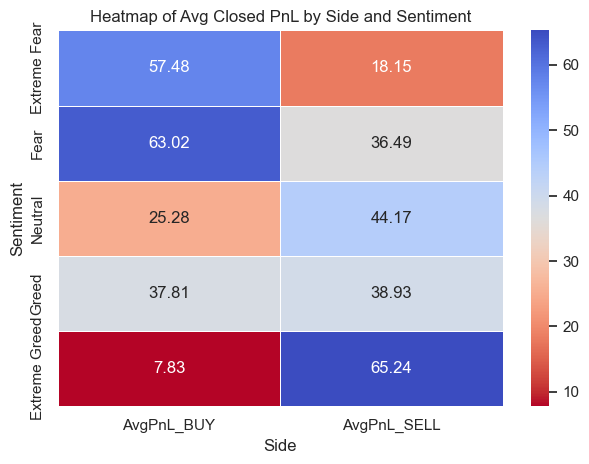

In [45]:
sns.heatmap(
    ordered_summary[['AvgPnL_BUY', 'AvgPnL_SELL']], 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm_r", 
    linewidths=0.5
)
plt.title("Heatmap of Avg Closed PnL by Side and Sentiment")
plt.xlabel("Side")
plt.ylabel("Sentiment")
plt.tight_layout()
plt.show()
